In [28]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
# stuff copied from part 1
words = open('_resources/names.txt', 'r').read().splitlines()

b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
        # print(ch1, ch2)

chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

N = torch.zeros((27, 27), dtype=torch.int32) # a tensor with shape (27,27)

In [249]:
# create the training set of all the bigrams

# xs: inputs
# ys: targets (labels - the correct next character in a sequence)
# => xy is a bigram
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs) # for ['emma']: [ 0,  5, 13, 13,  1]
ys = torch.tensor(ys) # for ['emma']: [ 5, 13, 13,  1,  0]

In [86]:
(xs,ys)

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

that up there is integers. we don't want to put those in the NN because it's multiplicative. so z=26 would be more than a=1

common solution: "One Hot Encoding"
- a vector that is all 0s except for the nth dimension, which we turn into 1

In [250]:
# x encoded
# one-hot: `b` is [0,1,0,...] etc (or [0,0,1,0,...] if the first character is start/end
# this matrix multiplication _feels_ expensive. but it's actually cheap
# because all elements but one are zero. so most multiplications can be skipped!
# (modern models use embeddings instead of one-hot encodings)

# 🚨 we repeat this next line further down. here just using it to show what xenc looks like
xenc = F.one_hot(xs, num_classes=27).float() # need to cast to float because we don't want ints in a neural net

In [88]:
xenc.shape

torch.Size([5, 27])

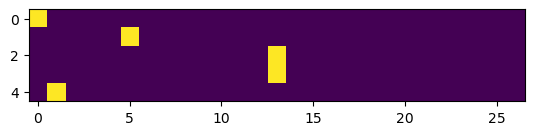

In [89]:
plt.imshow(xenc)

In [90]:
xenc.dtype

torch.float32

In [251]:
# neuron: wx+b
g = torch.Generator().manual_seed(2147483647)

W = torch.randn((27, 1), generator=g) # normal dist, column vector, [27,1]

# @ is matrix multiplication operator in pytorch
# xenc is [5,27], w is [27,1]
# matrix multiplication: inner dimensions (27 in this case) need to match
# example:
#
# A = [[1,2,3,4],
#      [5,6,7,8]]
#
# B = [[1,2,3],   or [[a,b,c],
#      [4,5,6],       [d,e,f],
#      [7,8,9],       [g,h,i],
#      [10,11,12]]    [j,k,l]]
#
# (2,4)@(4,3) => 2,3
#
# C(1,1) = 1a+2d+3g+4j C(1,2) = 1b+2e+3h+4k C(1,3) = 1c+2f+3i+4l
# C(2,1) = 5a+6d+7g+8j C(2,2) = 5b+6e+7h+8k C(2,3) = 5c+6f+7i+8l
#
# C(1,1) = 1*1+2*4+3*7+4*10=70
# C(2,3) = 5*3+6*6+7*9+8*12=210
# etc...
#
# C = [[70,80,90],[158,184,210]]
r = xenc @ W
r

tensor([[ 1.5674],
        [-0.0296],
        [ 0.0380],
        [ 0.0380],
        [-0.2373]])

In [253]:
# 🚨 why does this reuse lines from above? => oh, because above was demo for a single neuron

# instead of a single neuron, we want 27 neurons
# and in parallel evaluate all 27 neurons on all 5 inputs
# (5,27) @ (27,27) => (5,27)
# for each of the 27 neurons, what is the firing rate of those neurons
# on each of those 5 examples
# so r[3,13] gives us the firing rate of the 13th neuron looking at the 3rd input
# 
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

![neural net](./_resources/neural_net2.jpg)

We now have have
- 27 inputs (xenc) => input layer
- 27 neurons (they perform W*x, weights are W, no bias, no nonlinearity like tanh) => hidden layer
- we don't have a second hidden layer in this case

Now let's think about what the outputs should be
- what we're trying to produce is: for every input sample, a probability distribution for the next character in the distribution...
- ...but how will we interpret those 27 output numbers?
- we're using a normal distribution, so some are negative and some are positive. but we want them to represent probabilities which are 0-1 (and sum to 1)
- what the 27 output numbers are giving us is log counts
- to get the counts, we take the log counts and exponentiate them: x => e^x
- e^x: for negative numbers, you get <1, for positive numbers you get >1 until infinity

In [254]:
# plugging xs into a neural network... this is a forward pass

# input to the neural net: one-hot encoding
# need to cast to float because we don't want ints in a neural net
xenc = F.one_hot(xs, num_classes=27).float() 

# predict log-counts
# logits is a common term for log-counts
logits = xenc @ W

# counts, equivalent to the `N` array that we used in the bigram example
counts = logits.exp() 

# probabilities for the next character (normalized)
probs = counts / counts.sum(1, keepdims=True) 

# btw: the last 2 lines here are together called a "softmax"
probs

# 🚨 All off these layers are differentiable. So we can backpropagate through them!

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

## softmax

a type of normalization function

takes logits, exponentiates, divides and normalizes

it's a way of taking outputs from a neural network (can be positive or negative) and outputs positive numbers that sum to 1

you can put it on top of any other linear layer. and then it makes the neural network output probabilities.

![softmax](./_resources/softmax.jpeg)

In [97]:
# for every one of our 5 examples (".emma"), we now have a row that came out of a neural net
probs.shape

torch.Size([5, 27])

In [122]:
# we feed a dot into the neural net - get its index, one-hot encode it,
# goes into neural net, out comes this distribution of properties

# each of these numbers is how likely each of the 27 characters are to come next
# as we tune the weights W, the probabilities will change

# can we optimize and find a good W so the probabilities that come out are pretty good?
# ("pretty good" is measured by the loss function)

probs[0]

tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])

In [255]:
# there are five bigrams inside `.emma.`
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('-------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the current character:', p.item())
    logp = torch.log(p)
    print('log likelihood', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('==========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

-------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
       grad_fn=<SelectBackward0>)
label (actual next character): 5
probability assigned by the net to the current character: 0.012286250479519367
log likelihood -4.3992743492126465
negative log likelihood: 4.3992743492126465
-------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
       grad_fn=<SelectBackward0>)
label (actual next character): 13


In [256]:
# the random number we started with is not very good. but the solution
# is not to look for a better random number.
# we have a loss function now!

# next: similar to micrograd - convert integers to vectors, run forward pass,
# compute loss, backward pass, update

# forward pass is further up
# probs is our ypred

# probs.shape = [5,27] - first index is index into word, 2nd index is letter
# probs[0, 5] # 0th index of `.emma.` is `.`, odds that index 5 (`e`) follows it
# probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]
# ^ we want to do this but not manually
_probs = probs[torch.arange(5), ys]
logprobs = _probs.log()
avglogprobs = logprobs.mean()
loss = -avglogprobs
loss

tensor(3.7693, grad_fn=<NegBackward0>)

In [257]:
# backward pass
W.grad = None # make sure all gradients are set to 0

# like micrograd, pytorch builds a full computational graph
# retain_graph lets us run it multiple times
loss.backward(retain_graph=True) 

# now all the intermediate steps are filled in, so we can run:
# [27,27] just like W
# every element of W.grad tells us the influence of that weight on the loss function
# W.grad[0,0] is 0.0121 (positive), so W[0,0] += h would INCREASE the loss
W.grad

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [171]:
# update
# we don't need to loop over parameters because there is only one parameter
W.data += -0.1 * W.grad
W.data

tensor([[ 1.5637e+00, -2.3789e-01, -2.8124e-02, -1.1010e+00,  2.8487e-01,
          2.9619e-02, -1.5472e+00,  6.0350e-01,  7.8314e-02,  9.0275e-01,
         -4.7173e-01,  7.8515e-01, -3.2898e-01, -4.3346e-01,  1.3699e+00,
          2.9191e+00,  1.5582e+00, -1.6262e+00,  6.7567e-01, -8.4072e-01,
          9.8285e-01, -1.4903e-01, -1.4797e+00,  4.4711e-01, -7.1438e-02,
          2.4876e+00,  2.4360e+00],
        [-6.1096e-01, -1.2204e+00,  3.0077e-01, -1.0731e+00,  7.2398e-01,
          4.9266e-02,  1.3030e+00, -8.0299e-01, -8.5117e-01, -1.8070e+00,
          1.2462e+00, -1.2261e+00,  1.2106e+00, -9.6545e-01, -2.3350e-01,
         -3.4886e-01,  3.2999e-01, -1.3267e+00,  1.1170e+00,  5.9322e-01,
          4.5568e-01,  5.2157e-02, -1.7403e+00,  1.1362e-01,  7.9927e-01,
          5.3806e-01, -1.1652e+00],
        [ 1.4756e-01, -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01,
         -7.8305e-01,  1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,
          9.3743e-01, -8.8303e-01,  1.74

In [174]:
loss.item()

3.709091901779175

In [282]:
# we can now do gradient descent!

# all of this is copy pasted from above!
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()
print(loss.item())
W.grad = None
loss.backward()
W.data += -0.1 * W.grad

3.2995219230651855
